In [1]:
"""
ref: 
https://m.blog.naver.com/gdpresent/221717318894

"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import matplotlib.cm as cm
import seaborn as sns
sns.set_style("dark")

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Models
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from utils import learning_curve_plotter

In [2]:
# base param
seed = 712

In [3]:
cancer = load_breast_cancer()

# EDA

- 샘플 사이즈
- 다양한 피쳐의 크기
- 클래스 비율
- 디스크릿, 컨티뉴어스 피쳐

In [4]:
# cancer.data, cancer.target

# sample size
print(len(cancer.data))

# Class label ratio
unique, counts = np.unique(cancer.target, return_counts=True)
data_ratio = dict(zip(unique, counts))
print(data_ratio)

569
{0: 212, 1: 357}


In [5]:
X_train_origin, X_test_origin, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=712)

# data normalize 진행
sc = StandardScaler()
sc.fit(X_train_origin)

X_train = sc.transform(X_train_origin)
X_test = sc.transform(X_test_origin)


for i in range(X_train.shape[1]):
    print(f"Range after normalize feature {i}'s {min(X_train_origin[:, i])} ~ {max(X_train_origin[:, i])} to {min(X_train[:, i])} ~ {max(X_train[:, i])}")

Range after normalize feature 0's 6.981 ~ 28.11 to -2.023709111635772 ~ 3.991146816473824
Range after normalize feature 1's 10.38 ~ 39.28 to -2.1202942205717465 ~ 4.697162866739091
Range after normalize feature 2's 43.79 ~ 188.5 to -1.9796847236835322 ~ 3.994892215222493
Range after normalize feature 3's 143.5 ~ 2501.0 to -1.4454253671305324 ~ 5.260337816844935
Range after normalize feature 4's 0.05263 ~ 0.1634 to -3.0854752127382876 ~ 4.721618469874036
Range after normalize feature 5's 0.01938 ~ 0.3454 to -1.6525873306558152 ~ 4.6818014778519546
Range after normalize feature 6's 0.0 ~ 0.4108 to -1.1428129281297774 ~ 4.162608769068677
Range after normalize feature 7's 0.0 ~ 0.1913 to -1.2755093081043052 ~ 3.729200191616107
Range after normalize feature 8's 0.1167 ~ 0.2906 to -2.4703038289856485 ~ 4.166039770914361
Range after normalize feature 9's 0.04996 ~ 0.09744 to -1.7971653805580423 ~ 4.824523565809539
Range after normalize feature 10's 0.1115 ~ 2.873 to -1.0561779165370946 ~ 8.86

In [6]:
def score(X_train, y_train, X_test, y_test, model):
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f"score - train: {train_score}, test: {test_score}")

def metrics(true_label, predict_label):
    roc = roc_auc_score(true_label, predict_label)
    f1 = f1_score(true_label, predict_label)
    print(f"test metrics - roc: {roc}, f1: {f1}")

# Decision Tree

- pruning 반드시 포함 - dept에 대한 조정 필요
- information gain (ID3, GINI)등을 사용할 필요는 없지만, 설명해야함
- DT의 dept에 따라 복잡도 명시

In [7]:
tree_clf = tree.DecisionTreeClassifier(random_state=seed)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=712)

In [8]:
score(X_train, y_train, X_test, y_test, tree_clf)
metrics(y_test, tree_clf.predict(X_test))

score - train: 1.0, test: 0.9035087719298246
test metrics - roc: 0.908445945945946, f1: 0.9230769230769231


In [9]:
# classification report
classification_report(y_test, tree_clf.predict(X_test))

'              precision    recall  f1-score   support\n\n           0       0.82      0.93      0.87        40\n           1       0.96      0.89      0.92        74\n\n    accuracy                           0.90       114\n   macro avg       0.89      0.91      0.90       114\nweighted avg       0.91      0.90      0.90       114\n'

In [10]:
# Tree Pre-Pruning 작업 진행
# tree.export_text(tree_clf)


params = {
    'max_depth': [2,3,4,5,6,7,8,9,10],
    'criterion': ['gini', 'entropy']
}

"""
that macro weighs each class equally whereas micro weights each sample equally. If the distribution of classes is symmetrical (i.e. you have an equal number of samples for each class), then macro and micro will result in the same score.
https://datascience.stackexchange.com/questions/45974/micro-f1-and-macro-f1-are-equal-in-binary-classification-and-i-dont-know-why
"""

tree_grid_search = GridSearchCV(estimator=tree_clf, param_grid=params,
                           scoring='f1_micro', return_train_score=True,
                           verbose=3, n_jobs=-1)
tree_grid_search.fit(X_train, y_train)

# score(X_train, y_train, X_test, y_test, grid_search.best_estimator_)
# metrics(y_test, grid_search.best_estimator_.predict(X_test))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.3s finished


GridSearchCV(estimator=DecisionTreeClassifier(random_state=712), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='f1_micro', verbose=3)

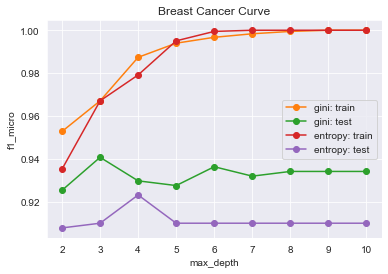

In [12]:
# grid_search.best_score_

tree_grid_search.cv_results_.keys()
tree_grid_search_result_df = pd.DataFrame(tree_grid_search.cv_results_)
tree_grid_search_result_df.sort_values(by="rank_test_score")

gini_df = tree_grid_search_result_df[tree_grid_search_result_df['param_criterion'].str.contains('gini')]
entropy_df = tree_grid_search_result_df[tree_grid_search_result_df['param_criterion'].str.contains('entropy')]

x_range=params['max_depth']
x_label="max_depth"
y_label="f1_micro"
title="Breast Cancer Curve"

gini_mean_train = gini_df["mean_train_score"]
gini_mean_test = gini_df["mean_test_score"]
entropy_mean_train = entropy_df["mean_train_score"]
entropy_mean_test = entropy_df["mean_test_score"]

plt.grid()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.plot(x_range, gini_mean_train, marker='o', label='gini: train', color=f"C{1}")
plt.plot(x_range, gini_mean_test, marker='o', label='gini: test', color=f"C{2}")
plt.plot(x_range, entropy_mean_train, marker='o', label='entropy: train', color=f"C{3}")
plt.plot(x_range, entropy_mean_test, marker='o', label='entropy: test', color=f"C{4}")

plt.legend()
plt.show()

In [13]:
# search for the best param
best_params = tree_grid_search_result_df["params"][np.argmax(tree_grid_search_result_df['mean_test_score'])]
best_score = np.max(tree_grid_search_result_df['mean_test_score'])

print(best_params, best_score)

# best parameter tester
best_tree_clf = tree.DecisionTreeClassifier(
    max_depth=3,
    random_state=seed,
    criterion='gini'
)

best_tree_clf.fit(X_train, y_train)

{'criterion': 'gini', 'max_depth': 3} 0.9406593406593406


DecisionTreeClassifier(max_depth=3, random_state=712)

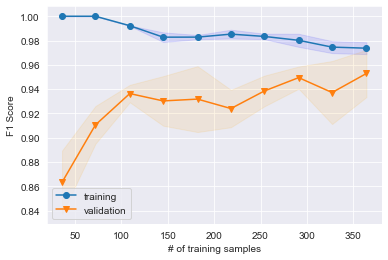

In [14]:
# Learning Curve Analysis

learning_curve_plotter(best_tree_clf, X_train, y_train)

In [16]:
# Test Set Performance

score(X_train, y_train, X_test, y_test, best_tree_clf)
metrics(y_test, best_tree_clf.predict(X_test))

score - train: 0.967032967032967, test: 0.9385964912280702
test metrics - roc: 0.9412162162162161, f1: 0.9517241379310345


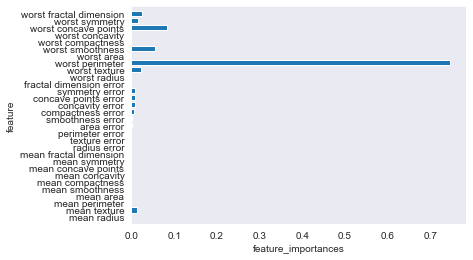

In [17]:
# feature importance

def plot_feature_importances(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features),
            model.feature_importances_,
            align='center')
    plt.yticks(np.arange(n_features),
              cancer.feature_names)
    plt.xlabel("feature_importances")
    plt.ylabel("feature")
    plt.ylim(-1, n_features)
    plt.show()
    
plot_feature_importances(tree_clf)

# # feature별 importance 매핑
# for name, value in zip(cancer.feature_names , best_tree_clf.feature_importances_):
#     print('{} : {:.3f}'.format(name, value))
    
# # feature importance를 column 별로 시각화 하기
# sns.barplot(x=best_tree_clf.feature_importances_ , y=cancer.feature_names)

## Neural Network

- actvation function & nn layer의 다양성 분석
- Learning rate와 momentum을 조정하여 NN의 학습을 빠르게할 수있음 (trade-off)는 있음
- Regularization은 overfitting을 방지 할 수 있음

In [18]:
nn_params = {
    "activation":["relu", "tanh"],
    "learning_rate_init": [0.1, 0.5, 0.7, 1],
    "momentum": [0, 0.5, 0.9],
    "alpha": [1e-5, 1e-4, 1e-3, 1e-2],
    "hidden_layer_sizes": [10, 30, 50],
    "max_iter": [1, 10, 50, 100]
}

nn_clf = MLPClassifier(random_state=seed)
nn_clf.fit(X_train, y_train)

nn_grid_search = GridSearchCV(estimator=nn_clf, param_grid=nn_params,
                           scoring='f1_micro', return_train_score=True,
                           verbose=3, n_jobs=-1)
nn_grid_search.fit(X_train, y_train)

/Users/user/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 3048 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 4472 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 5652 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:   22.1s finished


GridSearchCV(estimator=MLPClassifier(random_state=712), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [1e-05, 0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [10, 30, 50],
                         'learning_rate_init': [0.1, 0.5, 0.7, 1],
                         'max_iter': [1, 10, 50, 100],
                         'momentum': [0, 0.5, 0.9]},
             return_train_score=True, scoring='f1_micro', verbose=3)

In [19]:
# grid_search.best_score_

nn_grid_search.cv_results_.keys()
nn_grid_search_result_df = pd.DataFrame(nn_grid_search.cv_results_)
nn_grid_search_result_df.sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate_init,param_max_iter,param_momentum,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
539,0.135458,0.008985,0.001798,0.001066,relu,0.01,50,0.1,100,0.9,...,0.978022,0.006950,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
538,0.125049,0.011389,0.001200,0.000032,relu,0.01,50,0.1,100,0.5,...,0.978022,0.006950,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
537,0.137943,0.012603,0.001234,0.000089,relu,0.01,50,0.1,100,0,...,0.978022,0.006950,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
115,0.066226,0.014538,0.001357,0.000302,relu,1e-05,50,0.5,50,0.5,...,0.975824,0.008223,4,1.000000,1.000000,1.000000,0.997253,1.000000,0.999451,0.001099
114,0.062463,0.010215,0.001182,0.000060,relu,1e-05,50,0.5,50,0,...,0.975824,0.008223,4,1.000000,1.000000,1.000000,0.997253,1.000000,0.999451,0.001099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,0.004324,0.002418,0.001160,0.000028,tanh,1e-05,30,1,1,0.5,...,0.118681,0.036380,1141,0.112637,0.123626,0.134615,0.112637,0.107143,0.118132,0.009829
660,0.002974,0.000698,0.001137,0.000016,tanh,1e-05,30,1,1,0,...,0.118681,0.036380,1141,0.112637,0.123626,0.134615,0.112637,0.107143,0.118132,0.009829
806,0.002748,0.000326,0.001144,0.000037,tanh,0.0001,30,1,1,0.9,...,0.118681,0.036380,1141,0.112637,0.123626,0.134615,0.112637,0.107143,0.118132,0.009829
1092,0.002684,0.000139,0.001239,0.000172,tanh,0.01,30,1,1,0,...,0.118681,0.036380,1141,0.112637,0.123626,0.137363,0.109890,0.107143,0.118132,0.011126


ValueError: x and y must have same first dimension, but have shapes (3,) and (18,)

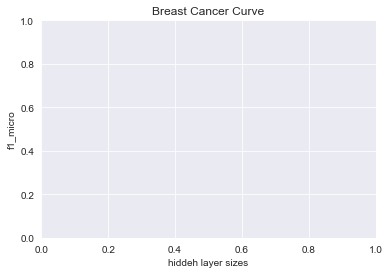

In [20]:
# grid_search.best_score_

nn_grid_search.cv_results_.keys()
nn_grid_search_result_df = pd.DataFrame(nn_grid_search.cv_results_)
nn_grid_search_result_df.sort_values(by="rank_test_score")

x_range=nn_params['hidden_layer_sizes']
x_label="hiddeh layer sizes"
y_label="f1_micro"
title="Breast Cancer Curve"

nn_mean_train = tree_grid_search_result_df["mean_train_score"]
nn_mean_test = tree_grid_search_result_df["mean_test_score"]

plt.grid()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.plot(x_range, nn_mean_train, marker='o', label='nn train', color=f"C{1}")
plt.plot(x_range, nn_mean_test, marker='o', label='nn test', color=f"C{2}")

plt.legend()
plt.show()

In [ ]:
# search for the best param
best_params = nn_grid_search_result_df["params"][np.argmax(nn_grid_search_result_df['mean_test_score'])]
best_score = np.max(nn_grid_search_result_df['mean_test_score'])

print(best_params, best_score)

In [40]:
# # best parameter tester
best_nn_clf = MLPClassifier(
    activation="relu",
    random_state=seed,
    alpha=0.01,
    hidden_layer_sizes=50,
    learning_rate_init=0.1,
    momentum=0,
    max_iter=100
)

best_nn_clf.fit(X_train, y_train)

MLPClassifier(alpha=0.01, hidden_layer_sizes=50, learning_rate_init=0.1,
              max_iter=100, momentum=0, random_state=712)

/Users/user/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/user/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/user/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/user/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/user/anaconda3/lib/python3.8/site-pac

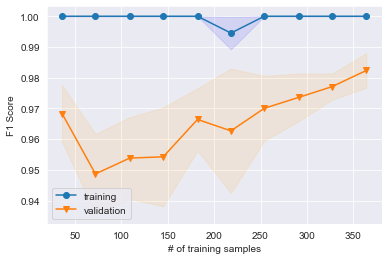

In [41]:
# Learning Curve Analysis

learning_curve_plotter(best_nn_clf, X_train, y_train)

In [42]:
score(X_train, y_train, X_test, y_test, nn_clf)
metrics(y_test, nn_clf.predict(X_test))

score - train: 0.9912087912087912, test: 0.9736842105263158
test metrics - roc: 0.9797297297297297, f1: 0.9793103448275862


## Boosting
- bias와 varience의 영향을 가장 적게 받을 것임

In [38]:
boosting_params = {
    "n_estimators":[1, 10, 50, 100, 200, 300, 500],
    "learning_rate": [0.1, 0.5, 0.7, 1],
}

ada_clf = AdaBoostClassifier(random_state=seed)

ada_grid_search = GridSearchCV(estimator=ada_clf, param_grid=boosting_params,
                           scoring='f1_micro', return_train_score=True,
                           verbose=3, n_jobs=-1)
ada_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    7.8s finished


GridSearchCV(estimator=AdaBoostClassifier(random_state=712), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 0.7, 1],
                         'n_estimators': [1, 10, 50, 100, 200, 300, 500]},
             return_train_score=True, scoring='f1_micro', verbose=3)

In [97]:
best_params = ada_grid_search_result_df["params"][np.argmax(ada_grid_search_result_df['mean_test_score'])]
best_score = np.max(ada_grid_search_result_df['mean_test_score'])

In [72]:
param_list = [i for i in ada_grid_search_result_df.keys() if i.startswith("param_")]
new_df = pd.DataFrame(ada_grid_search_result_df, columns=[i for i in ada_grid_search_result_df.keys() if i != 'params'])

In [78]:
new_df2 = new_df.set_index(param_list)

In [83]:
new_df3 = new_df2.drop(axis=1, labels=[i for i in new_df2.columns if i.startswith("split")])

In [85]:
lr1 = new_df3.xs(0.1, level="param_learning_rate")

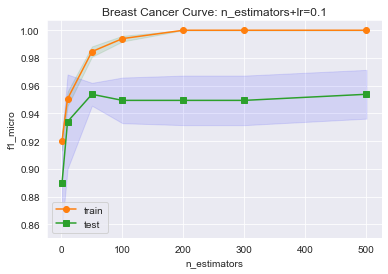

In [102]:
# grid_search.best_score_

ada_grid_search.cv_results_.keys()
ada_grid_search_result_df = pd.DataFrame(ada_grid_search.cv_results_)
ada_grid_search_result_df.sort_values(by="rank_test_score")

param_name = "n_estimators"

x_range = boosting_params[param_name]
x_label = param_name
y_label = "f1_micro"
title=f"Breast Cancer Curve: {param_name}+lr=0.1"

mean_train = lr1["mean_train_score"]
mean_test = lr1["mean_test_score"]
std_train = lr1["std_train_score"]
std_test = lr1["std_test_score"]

plt.grid()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.plot(x_range, mean_train, marker='o', label='train', color=f"C{1}")
plt.fill_between(x_range, mean_train+std_train, mean_train-std_train, color='green', alpha=0.1)
plt.plot(x_range, mean_test, marker='s', label='test', color=f"C{2}")
plt.fill_between(x_range, mean_test+std_test, mean_test-std_test, color='blue', alpha=0.1)

plt.legend()
plt.show()

In [108]:
ada_grid_search.best_estimator_.predict(X_test)

array([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0])

In [111]:
score(X_train, y_train, X_test, y_test, ada_grid_search)
metrics(y_test, ada_grid_search.predict(X_test))

score - train: 1.0, test: 0.956140350877193
test metrics - roc: 0.9547297297297297, f1: 0.9659863945578231


In [26]:
# grad_clf = GradientBoostingClassifier(
#     learning_rate=0.1,
#     n_estimators=1000,
#     max_depth = 3, # no more than 5 usually
#     max_features=0.6,
#     subsample=0.7,
#     random_state=seed
# )
# grad_clf.fit(X_train, y_train)

# score(X_train, y_train, X_test, y_test, grad_clf)
# metrics(y_test, grad_clf.predict(X_test))

GradientBoostingClassifier(max_features=0.6, n_estimators=1000,
                           random_state=712, subsample=0.7)

## SVM

In [ ]:
# https://idkim97.github.io/machine%20learning/MachineLearning_SVM/

svm_clf = svm.SVC(kernel='rbf', C=2, gamma=0.5) #gamma 
svm_clf.fit(X_train, y_train)

In [ ]:
score(X_train, y_train, X_test, y_test, svm_clf)
metrics(y_test, svm_clf.predict(X_test))

In [ ]:
#gamma와 c를 바꿔가며 최적의 값 찾기
gamma_list = [0.5, 2, 10, 100, 100]
for gamma in gamma_list:
    svm_clf = svm.SVC(kernel='rbf', C=10, gamma=gamma) #gamma 
    svm_clf.fit(X_train, y_train)
    score(X_train, y_train, X_test, y_test, svm_clf)

## K-NN

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_train)

In [ ]:
score(X_train, y_train, X_test, y_test, knn_clf)
metrics(y_test, knn_clf.predict(X_test))